# Aprendizaje Automático

## Tarea 3

Profesor: MSc. Felipe Meza.

Instituto Tecnológico de Costa Rica, 

Medio de entrega: TecDigital.

Entregables: El entregable consiste en el url de la notebook Tarea-3.ipynb en GITHUB. 

Grupo de trabajo:
- Manuel Calderón
- Ernesto Rivera

---
Objetivo: El objetivo de la Tarea 3 consiste en elegir un conjunto de datos de mediana complejidad que no sea trivial, y aplicarle algunos algoritmos supervisados de su elección

# Métricas para evaluación de los modelos de aprendizaje supervisado

Dado a que es muy importante llevar a cabo una correcta evaluación de los modelos en los sistemas de aprendizaje automatico, se debnen realizar las correctas metricas de evaluacion, de acuerdo al respectivo enfoque de como se aplique la tarea, dentro del aprendizaje supervizado existen 2 enfoques que serían clasificación y regresión.

Para el caso de la explicación desglozaremos las distintas méticas de acuerso a si son de rgresión o clasificación:

**NOTA:** para estos ejemplos y definiciones nos se utilizaron los siguientes enlaces

**Regresión:**

https://sitiobigdata.com/2019/05/27/aprendizaje-automatico-seleccionando-metricas-regresion/#

https://sitiobigdata.com/2019/05/27/modelos-de-machine-learning-metricas-de-regresion-mse-parte-2/

**Clasificación:**

https://sitiobigdata.com/2019/01/19/machine-learning-metrica-clasificacion-parte-3/#

**Ejemplos de código en general:**

https://scikit-learn.org/stable/modules/model_evaluation.html



## Métricas de regresión

**Error cuadrático medio (MSE)**

Es quizás la métrica sencilla y mas usada para la evaluación de regresión. 

Se define por la ecuación:

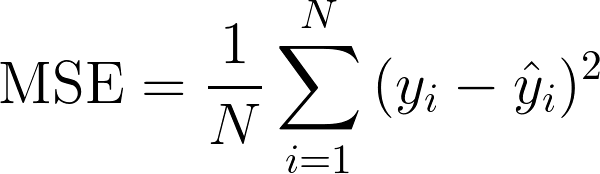

Con yᵢ es el resultado real esperado y ŷᵢ es la predicción del modelo.

Esta métrica mide el error cuadrado promedio de nuestras predicciones. Para cada punto, calcula la diferencia cuadrada entre las predicciones y el objetivo y luego promedia esos valores.

Cuanto mayor sea este valor, peor es el modelo, además la sumatoria al ser cuadrada nunca será negatica.

Ventaja: tiene ventaja su utilidad para medir valoes inesperados, ya que si el valor es muy alto o muy bajo se debe prestar la atención debida.

Desventaja: si la prediccion es muy mala, al ser cuadrado esta será aun peor ya que se podria sobreestimar lo malo del del modelo (esto se ve más aún en datos no confiables). También puede pasar el caso contrario dende los eerores son my pequeñosy se sobreestima lo bueno del modelo.

Ejemplo de sklearn:

In [1]:
from sklearn.metrics import mean_squared_error

y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]

mean_squared_error(y_true, y_pred)

0.7083333333333334

**Error cuadrático medio (RMSE)**

RMSE es aplica una raíz cuadrada al MSE, esto permite que la escala de los errores sea igual a la escala de los objetivos.

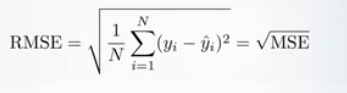

La diferencia principal es en el uso de modelos basados en gradiente, ya que se usa una tasa de flujo diferente, aunque esta dependa de la puntuación del MSE. Y lo por lo tanto no pueden ser intercmabiables en estos métodos, ya que requeriría un ajuste el los parametros de aprendizaje,

Ejemplo:

In [2]:
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]

mean_squared_error(y_true, y_pred, squared=False)

0.8227486121839513


**Error absoluto medio (MAE)**

El calculo se aplica como un promedio de diferencias absolutas entre los valores objetivo y las predicciones, esta utiliza una puntuación lineal (todas las diferencias individuales se ponderan por igual en el promedio).

Se calcula utilizando esta fórmula:

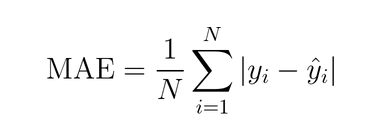

Esta métrica penaliza lo errores enormes y por lo tanto no es tan sencible a errores atipicos como MSE, así que da una ventaja si existen outliers en la data.


Ejemplo:

In [3]:
from sklearn.metrics import mean_absolute_error

y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]

mean_absolute_error(y_true, y_pred)

0.75

**R al cuadrado (R²)**

Representa la proporción de varianza (de y) que ha sido explicada por las variables independientes en el modelo, está estrechamente relacionada con la MSE, pero tiene la ventaja de estar libre de escala, por lo tanto, el R² siempre estará entre -∞ y 1.

Cuando R² es negativo, significa que el modelo es peor que predecir la media.

Se aplica con la siguiente fórmula:

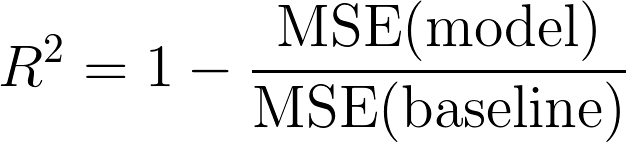

Con MSE(model) utiliza la fórmula normal y el baseline la siguiente:

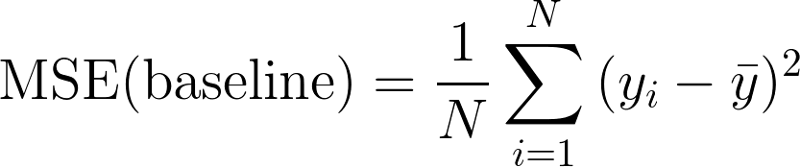

Con la y con barra es la media de la y observada.

Ejemplo:

In [4]:
from sklearn.metrics import r2_score

y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]


# ‘variance_weighted’: Scores of all outputs are averaged, weighted by the variances of each individual output.
r2_score(y_true, y_pred, multioutput='variance_weighted')

0.9382566585956417

**R cuadrado ajustado (R²)**

El R2 ajustado indica qué tan bien se ajustan los términos a una curva o línea, pero aplicando un ajuste al número de términos del modelo. Este indica el porcentaje de variación explicado solo por las variables independientes que realmente afectan la variable dependiente.

Se calcula de la siguiente manera:

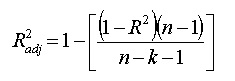

Con n el número total de observaciones y k el número de regresores independientes.

Ejemplo:

In [5]:
from sklearn.metrics import r2_score

y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]


# ‘variance_weighted’: Scores of all outputs are averaged, weighted by the variances of each individual output.
r2_score(y_true, y_pred, multioutput='variance_weighted')

# print(1-(1-r2_score(y_true, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

0.9382566585956417

**Error porcentual absoluto medio (MAPE)**

Para cada objeto, el error absoluto se divide por el valor objetivo, dando un error relativo. Es cosiderado como versiones poderadas del MAE.

![image.png](attachment:image.png)

En esta métrica el peso de la muestra es inversamente proporcional a su objetivo y las predicciones constantes óptimas resultan ser la mediana ponderada de los valores objetivo.

Un problema de esta métrica es que si existieran valores atipicos muy pequeños, el método se ve sesagado hacia esos valores por el peso que se le dan.

Ejemplo:

In [6]:
from sklearn.metrics import mean_absolute_percentage_error

y_true = [1, 10, 1e6]
y_pred = [0.9, 15, 1.2e6]

mean_absolute_percentage_error(y_true, y_pred)

0.26666666666666666

**Error logarítmico cuadrático medio (RMSLE)**

Esta métrica aplica un RMSE pero calculado en escala logarítmica, para ello se toma un logaritmo de las preducciones y los valores objetivos. 

Por lo general los objetivos no son negativos pero pueden ser 0, dando que logaritmo sea indefinido, por que se deben agrear constantes a las predicciones y objetivos para evitar dicho error (Esta constante varia dependiendo del problema).

Como ventaja del RMSLE es que penaliza las estimaciones poco predichas aún más que las estimaciones sobre pronosticadas.

La fórmula aplicada es la siguiente:

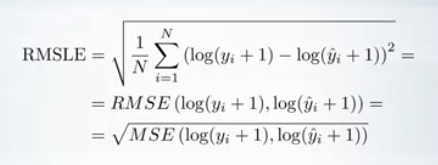


Ejemplo:

In [7]:
from sklearn.metrics import mean_squared_log_error

y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]

mean_squared_log_error(y_true, y_pred)

0.03973012298459379

## Métricas de clasificación


**Matriz de confusión o error**

Esta es una tabla que describe el rendimiento de un modelo supervisado en los datos de prueba, donde se desconocen los verdaderos valores. Este hace que sea fácil detectar dónde el sistema está confundiendo dos clases.

Donde se aplican estas reglas:

True Positives (TP): cuando la clase real del punto de datos era 1 (Verdadero) y la predicha es también 1 (Verdadero)

Verdaderos Negativos (TN): cuando la clase real del punto de datos fue 0 (Falso) y el pronosticado también es 0 (Falso).

False Positives (FP): cuando la clase real del punto de datos era 0 (False) y el pronosticado es 1 (True).

False Negatives (FN): Cuando la clase real del punto de datos era 1 (Verdadero) y el valor predicho es 0 (Falso).

Muchos de las métricas de clasificación usan como base la matriz de confusión y el manejo de estas reglas.

Ejemplo:

In [8]:
from sklearn.metrics import confusion_matrix

y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]

confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

**Accuracy - Precisión**

Es el porcentaje total de elementos clasificados correctamente. Su valor valor va entre 0 y 1 (entre más alto mejor).

Se maneja de la siguiente forma:

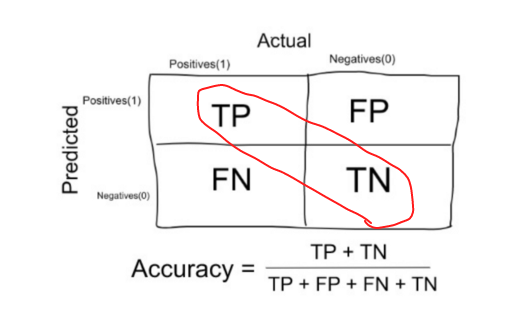
 
Tiene la desventaja, de que se generan problemas si las clases de variables no están balanceadas, así que Accuracy es una buena medida a usar cuando los datos están casi equilibradas.



In [9]:
import numpy as np
from sklearn.metrics import accuracy_score

y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]

accuracy_score(y_true, y_pred)

0.5

**Recall o sensibilidad o TPR (Tasa positiva real)**

Es el número de elementos identificados correctamente como positivos del total de positivos verdaderos. El recall nos da información sobre el rendimiento de un clasificador con respecto a falsos negativos (cuántos fallaron).

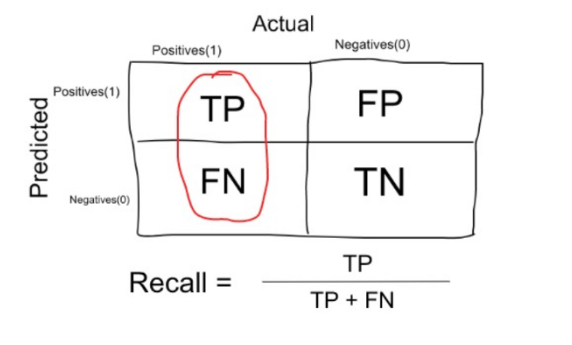

Ejemplo:


In [10]:
from sklearn.metrics import recall_score

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

# Calculate metrics globally by counting the total true positives, false negatives and false positives.
recall_score(y_true, y_pred, average='micro')

0.3333333333333333

**Precisión**

Es el número de elementos identificados correctamente como positivo entre total de elementos identificados como positivos (sean o no positivos realmente).

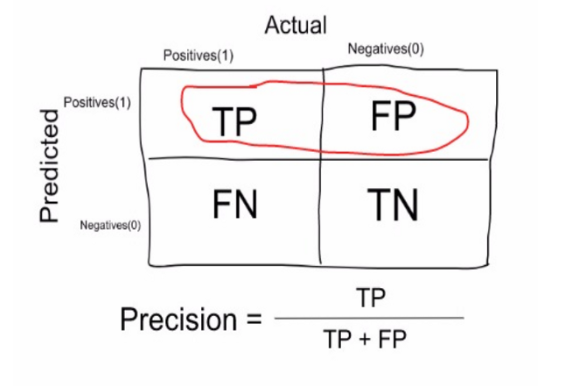


La precisión nos proporciona información sobre su rendimiento con respecto a los falsos positivos (cuántos capturados). Si queremos enfocarnos en minimizar los falsos positivos, entonces esta métrica es la ideal cuando se busca estar lo más cerca del 100%.

Ejemplo:

In [11]:
from sklearn.metrics import precision_score

y_true = [0, 1, 2, 0, 1, 2]

y_pred = [0, 2, 1, 0, 0, 1]

# Calculate metrics globally by counting the total true positives, false negatives and false positives.
precision_score(y_true, y_pred, average='micro')

0.3333333333333333

**Especificidad o TNR (Tasa negativa real)**

Es el número de ítems correctamente identificados como negativos entre total de elementos negativos (la especificidad es exactamente lo opuesto a Recall).

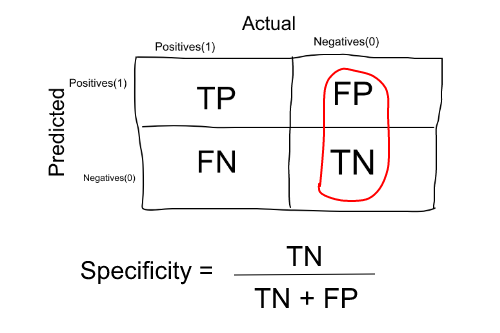

Ejemplo:


In [12]:
from sklearn.metrics import confusion_matrix

y_true = [0, 0, 0, 1, 1, 1, 1, 1]
y_pred = [0, 1, 0, 1, 0, 1, 0, 1]

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

specificity = tn / (tn+fp)

print(specificity)

0.6666666666666666


**F1-Score**

La precisión es un ejemplo de una métrica de evaluación de un solo número y le permite comparar rápidamente dos clasificadores.

Mientras que el recall da 2 números para evaluar su clasificador.

Es mejor si podemos obtener una sola puntuación que representa tanto Precisión (P) como recall (R).

Una forma de hacerlo es con un promedio ponderado entre la precisión y el Recall, donde 1 es el mejor valor y el 0 el peor. 

Se aplica la siguiente fórmula:

F1 = 2 * (precision * recall) / (precision + recall)

In [13]:
from sklearn.metrics import f1_score

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

f1_score(y_true, y_pred, average='micro')

0.3333333333333333



**Área bajo la curva de funcionamiento del receptor (ROC) (AUC)**

Entre las métricas de clasificación se tiene la curva AUC-ROC, donde ROC viene de las características de funcionamiento del receptor y AUC del área bajo la curva.

La curva ROC nos dice qué tan bueno puede distinguir el modelo entre dos cosas, por ejemplo, si un paciente tiene cáncer o no. 

El AUC es el área bajo la curva ROC. Este puntaje nos da una buena idea de qué tan bien funciona el modelo.

Tomado de https://aprendeia.com/curvas-roc-y-area-bajo-la-curva-auc-machine-learning/

Ejemplo:


In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X, y = load_breast_cancer(return_X_y=True)
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)

roc_auc_score(y, clf.decision_function(X))

0.9947016542466043

**Pérdida logarítmica**

Obtiene la reducción de la pérdida de registro del clasificador. Este proporciona una medida de cuánto mejora un modelo, dnde el modelo que proporciona predicciones aleatorias. La reducción de la pérdida de registros más cercana a 1 indica un modelo mejor.

Tomado de https://docs.microsoft.com/es-es/dotnet/api/microsoft.ml.data.multiclassclassificationmetrics.loglossreduction?view=ml-dotnet#Microsoft_ML_Data_MulticlassClassificationMetrics_LogLossReduction

Ejemplo:

In [15]:
from sklearn.metrics import log_loss

log_loss(["spam", "ham", "ham", "spam"],
         [[.1, .9], [.9, .1], [.8, .2], [.35, .65]])

0.21616187468057912


**Cohen’s Kappa**

Esta métrica se usa a menudo para evaluar el acuerdo entre dos evaluadores, también se puede utilizar para evaluar el rendimiento de los modelos. 

Una ventaja esta toma en cuenta el desequilibrio en la distribución de clases y, por lo tanto, puede ser más complejo de interpretar.

Tomado de https://www.knime.com/blog/cohens-kappa-an-overview

Ejemplo:

In [16]:
from sklearn.metrics import cohen_kappa_score

y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]

cohen_kappa_score(y_true, y_pred)

0.4285714285714286

# Manejo y preprocesado de datos


Para el ejemplo de los algoritmos supervisados se escogió el dataset de Agora.csv, utilizado en la tarea 2, ya que proporciona bastantes datos a trabajar.


In [17]:
import numpy as np
import pandas as pd
import torch as torch
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
## función para graficar
def graficar(X, Y1, Y2, xlabel, ylabel):
    
    if Y2:
        _, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

        ax1.plot(X, Y1)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax2.set_xlabel(xlabel)
        ax2.plot(X, Y2)
    else:
        plt.plot(X, Y1)
        plt.xlabel(xlabel)        
        plt.ylabel(ylabel)

    plt.suptitle("Error datos de entrenamiento y datos de prueba")
    plt.tight_layout(pad=3.0)

    plt.show()

In [19]:
## reemplazos textuales para curar los datos del dataset
replacements = [
["\"This Listing Is For Verified", "This Listing Is For Verified", -1],
["\"This subtropical", "This subtropical", -1],
["\"This po", "This po", -1],
["\"Mr. H", "Mr. H", -1],
["\"An engaging", "An engaging", -1],
[",\"Professional F", ",Professional F", -1],
[",\"Professional D", ",Professional D", -1],
["SKU:90183\"", "SKU:90183", -1],
["\"Encryption", "Encryption", -1],
["\"ProSoma", "ProSoma", -1],
["\"If you’", "If you’", -1],
[",\"Named", "Named", -1],
[",\"THC", ",THC", -1],
["\"Strassman'", "Strassman'", -1],
["\"You d", "You d", -1],
[",\"This is your", ",This is your", -1],
["35,\"P", "35,P", -1],
["wing,\"", "wing,", -1],
["22,\"I", "22,I", -1],
[",\"G13", ",G13", -1],
["0,\"Pl", "0,Pl", -1],
["s Sunglasses Replica are 1:1  ...", "s Sunglasses Replica are 1:1 ...\"", -1],
["],,,,", "],", -1],
[",David Icke (", ",\"David Icke (", -1],
["r Bud,I", "r Bud,\"I", -1],
["hone,B", "hone,\"B", -1],
["h,I r", "h,\"I r", -1],
[".,0.01547", ".\",0.01547", -1],
["~5/5,,", "~5/5,", -1],
[".,2.32555", ".\",2.32555", -1],
["/5,,", "/5,", -1],
[".,0.130088", ".\",0.130088", -1],
["tazepam,", "tazepam\",", -1],
["E,15.8", "E\",15.8", -1],
["Quality\"\" we've all come to know and love. This MD ...\",1", 
                        "Quality we've all come to know and love. This MD ...,1", -1] ]

with open("Agora2.csv", "wb") as nuevoArchivo: # trunca el archivo si ya existe
    with open("Agora.csv", mode="r", encoding="UTF-8", errors="ignore") as archivoOriginal:
        numero = 1
        for linea in archivoOriginal:
            if numero == 5000:
                break
            try:
                # se corrigen los errores encontrados
                for rep in replacements:
                    modified = False
                    if rep[0] in linea:
                        if not modified:
                            rep[2] = numero
                            modified = True
                        linea = linea.replace(rep[0], rep[1])
                
                # se almacena el texto en el nuevo archivo
                linea = linea.encode("utf-8")
                nuevoArchivo.write(linea)
            except Exception as e:
                print("Error con el string", numero, linea, e)
                raise e
            finally:
                numero += 1

# replacements

In [20]:
df = pd.read_csv("Agora2.csv")
df.describe()

,Vendor,Category,Item,Item Description,Price,Origin,Destination,Rating,Remarks
count,4998,4998,4998,4998,4998,3521,1525,4998,721
unique,339,21,4953,3930,4870,61,84,74,1
top,fake,Drugs/Prescription,Social Engineering: The Art of Human Hacking,This shipment is with tracking number. The shi...,0.00415549 BTC,USA,Worldwide,5.00/5,Average price may be skewed outliar > .5 BTC f...
freq,467,1057,3,96,29,691,492,839,721


In [21]:

print('Cantidad de filas iniciales:', df.shape[0])

# queda en 10737 si outliers
df = df[df[" Remarks"] != "Average price may be skewed outliar > .5 BTC found"]
print('Cantidad de filas sin outliars:', df.shape[0])

# Elimina entradas sin rating
df.dropna(subset = [" Rating"], inplace=True)
print('Cantidad de filas con rating no nulo:', df.shape[0])

# se deja los Ratings válidos - que terminan en '/5'
df = df[df[" Rating"].str.endswith("/5")]
print('Cantidad de filas con ratings válidos:', df.shape[0])

# Todas las entradas tienen precio, entonces **no elimina** ninguna fila
df.dropna(subset = [" Price"], inplace=True)
print('Cantidad de filas con precio:', df.shape[0])

# Verifica la cantidad de entradas que terminan con 'BTC'
print('cantidad de precios en BTC:', df[" Price"].str.endswith('BTC').count() )

# texto a números
df[" Price"]  = df[" Price"].str.replace(" BTC" , "")
df[" Rating"] = df[" Rating"].str.replace("/5" , "")
df[" Rating"] = df[" Rating"].str.replace("~" , "")
df[" Price"]  = pd.to_numeric(df[" Price"], errors ="coerce")
df[" Rating"] = pd.to_numeric(df[" Rating"], errors ="coerce")



# eliminar features no necesarios
df.drop(columns=[" Item", " Item Description", " Origin", " Destination", " Remarks"], inplace=True)
print('Columnas restantes:', df.columns)

df.describe()

Cantidad de filas iniciales: 4998
Cantidad de filas sin outliars: 4277
Cantidad de filas con rating no nulo: 4277
Cantidad de filas con ratings válidos: 4088
Cantidad de filas con precio: 4088
cantidad de precios en BTC: 4088
Columnas restantes: Index(['Vendor', ' Category', ' Price', ' Rating'], dtype='object')


,Price,Rating
count,4.088000e+03,4088.000000
mean,6.705033e+00,4.866215
std,3.511620e+02,0.337424
min,1.000000e-07,0.000000
25%,2.818479e-02,4.827750
50%,1.000080e-01,4.960000
75%,2.541704e-01,4.994000
max,2.198500e+04,5.000000


In [22]:
def soloCategoria(cat):
    posInicio = cat.find("/")
    if posInicio == -1:
        return cat
    
    posFin = cat.rindex("/")
    if posInicio == posFin:
        return cat[posInicio+1:]
    return cat[posInicio+1:posFin]

# usa la subcategoría
df[" Category"] = df[ " Category" ].apply(soloCategoria)

# codifica la categoría usando one-hot-encoding
oneHotEncoded = pd.get_dummies(df, columns=[" Category"], prefix="Cat")


## Retorna la categoría correspondiente al rating.
## El valor Rating de los datos está en el rango [2.6, 5.0]
## Categorías resultantes:
## - 2: bueno
## - 1: regular
## - 0: malo
def categoriasDeRating(valor):
    if valor > 4.1:
        return 2 # bueno
    if valor > 3.2:
        return 1 # regular
    return 0 #malo

df[" RatingClass"] = df[ " Rating" ].apply(categoriasDeRating)

In [23]:
print(df[" Rating"])
oneHotEncoded.drop(columns=["Vendor", " Rating"], inplace=True)
print("Datos codificados usando one-hot-encoding", oneHotEncoded.shape[0])
print("Total columnas: ", oneHotEncoded.shape[1], oneHotEncoded.columns)

0       4.96
1       4.96
2       4.93
3       4.89
4       4.88
        ... 
4993    4.96
4994    4.67
4995    4.96
4996    4.96
4997    4.96
Name:  Rating, Length: 4088, dtype: float64
Datos codificados usando one-hot-encoding 4088
Total columnas:  20 Index([' Price', 'Cat_Accounts', 'Cat_Clothing', 'Cat_Electronics',
       'Cat_Guides', 'Cat_Hacking', 'Cat_Jewelry', 'Cat_Money', 'Cat_Other',
       'Cat_Physical documents', 'Cat_Pipes', 'Cat_Pirated',
       'Cat_Prescription', 'Cat_RCs', 'Cat_Scans', 'Cat_Smoked',
       'Cat_Software', 'Cat_Steroids', 'Cat_Weight loss', 'Cat_eBooks'],
      dtype='object')




# Métodos escogidos 

Para los algoritmos escogidos se usaran:

- Regresión lineal: es una aproximación para modelar la relación entre una variable escalar dependiente “y” y una o mas variables explicativas nombradas con “X”. Tomado de https://www.aprendemachinelearning.com/tag/regresion-lineal/
- Árboles de decisión: 
-


**Regresión Lineal**

In [24]:
## datos para usar regresión
X_train, X_test, Y_train, Y_test = train_test_split(oneHotEncoded, df[" Rating"], random_state=13)
print("Cantidad de valores para entrenar:", Y_train.shape[0])
print("Cantidad de valores para comprobar:", Y_test.shape[0])

Cantidad de valores para entrenar: 3066
Cantidad de valores para comprobar: 1022


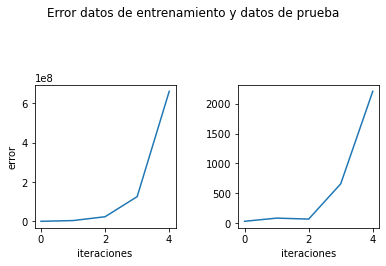

In [25]:
# regresión lineal usando pytorch

## modelo lineal
def modeloLineal(x, w, b):
    return x @ w + b

## función de cálculo de error, usando mse
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()


## Calcula un epoch más para la regresión lineal
def regresionLinealForward(metrica, inputs, targets, w, b):
    preds = modeloLineal(inputs, w, b)
    loss = metrica(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()
        error = loss.numpy()
    return error

## Va entrenando la regresión lineal y calculando la tasa de error
## de los datos para pruebas
def testRegresionLineal():
    # convierte a tensor de pytorch
    inputs = torch.tensor(X_train.values)
    target = torch.tensor(Y_train.values)
    
    inputs_test = torch.tensor(X_test.values)
    target_test = torch.tensor(Y_test.values)
    
    # valores iniciales, aleatorios
    torch.manual_seed(0)
    w = torch.randn(inputs.shape[1], 1, dtype=torch.float64, requires_grad=True)
    b = torch.randn(1, dtype=torch.float64, requires_grad=True)
    
    # epochs
    iteraciones = range(5)
    erroresEntrenamiento = []
    erroresPruebas = []
    for i in iteraciones:
        # un paso de entrenamiento
        errorEntrenamiento = regresionLinealForward(mse, inputs, target, w, b)
        erroresEntrenamiento.append(errorEntrenamiento)
        
        # test con el modelo resultante
        predicciones = modeloLineal(inputs_test, w, b)
        errorTest = mse(predicciones, target_test)
        with torch.no_grad():
            erroresPruebas.append(errorTest.numpy())
        
    #print(erroresEntrenamiento)
    #print(erroresPruebas)
    graficar(iteraciones, erroresEntrenamiento, erroresPruebas, "iteraciones", "error")
    
testRegresionLineal()

**Árboles de decisión**

In [26]:
## datos para usar clasificación
X_class_train, X_class_test, Y_class_train, Y_class_test = train_test_split(oneHotEncoded, df[" RatingClass"], random_state=13)

[0.987279843444227, 0.987279843444227, 0.9863013698630136, 0.9853228962818004]


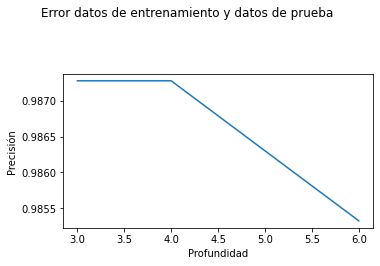

In [27]:
## Función auxiliar
def ajustarYEvaluarModelo(modelo):
    modelo.fit(X_class_train, Y_class_train)
    y_predict = modelo.predict(X_class_test)
    acc = accuracy_score(Y_class_test, y_predict)
    return acc

## Utilizando árboles de decisión

def testDecisionTree():
    profundidades = range(3, 7)
    precision = []
    for i in profundidades:
        modelo = DecisionTreeClassifier(max_depth = i)
        precision.append(ajustarYEvaluarModelo(modelo))

    print(precision)
    graficar(profundidades, precision, None, "Profundidad", "Precisión")

testDecisionTree()

**Random forest**

[0.987279843444227, 0.987279843444227, 0.987279843444227, 0.987279843444227]


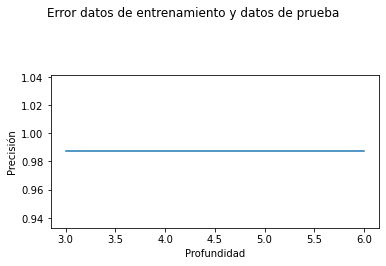

In [28]:
## Utilizando random forest
def testRandomForest():
    profundidades = range(3, 7)
    precision = []
    for i in profundidades:
        modelo = RandomForestClassifier(min_samples_leaf=3, max_depth=i)
        precision.append(ajustarYEvaluarModelo(modelo))

    print(precision)
    graficar(profundidades, precision, None, "Profundidad", "Precisión")

testRandomForest()

In [29]:
df=df[df[" Price"] <= 5]

df.fillna(df[" Price"].median(), inplace = True)
df.fillna(df[" Rating"].median(), inplace = True)
df = df.round({" Rating": 2, " Price": 4})

In [30]:
val = {}
ind_val = 1
for cate in df[" Category"].unique():
    if cate not in val:
        val.update({cate: ind_val})
        ind_val += 1

def cateToNum(cat):
    if cat in val:
        return val[cat]

# usa la subcategoría
df[" Category"] = df[ " Category" ].apply(cateToNum)

# codifica la categoría
print(val)

{'Hacking': 1, 'Other': 2, 'RCs': 3, 'Physical documents': 4, 'Smoked': 5, 'Money': 6, 'Software': 7, 'Accounts': 8, 'Clothing': 9, 'eBooks': 10, 'Electronics': 11, 'Pipes': 12, 'Weight loss': 13, 'Pirated': 14, 'Steroids': 15, 'Prescription': 16, 'Guides': 17, 'Scans': 18, 'Jewelry': 19}


In [31]:
val3 = {}
ind_val3 = 1
for cate in df["Vendor"].unique():
    if cate not in val:
        val3.update({cate: ind_val3})
        ind_val3 += 1

def vendorToNum(cat):
    if cat in val3:
        return val3[cat]

df["Vendor"] = df[ "Vendor" ].apply(vendorToNum)

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

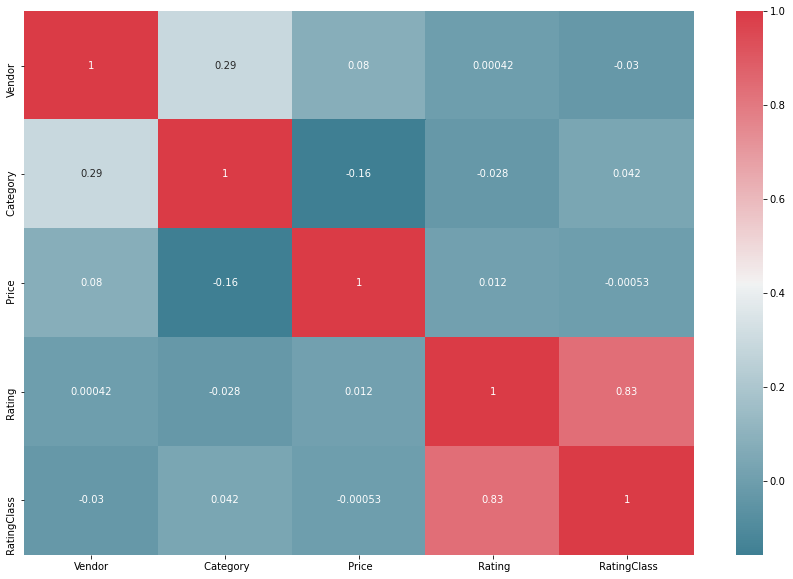

In [33]:
_,ax=plt.subplots(figsize=(15,10))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(df.corr(),annot=True,cmap=colormap)

# Métodos de ensamble

El objetivo de los métodos de emsamble es combinar las predicciones de varios estimadores con un algoritmo de aprendizaje así hacer una prediccion general más robusta. 

Por lo general, se distinguen dos familias de métodos de ensamble:

- En los métodos de promediado: Estos métodos aplican varias predicciones o estimaciones independientes y luego las promedia, esto por lo general da un mejor resultado que cualquiera de las estimaciones independientes. Ejemplos: Bagging methods, Forests of randomized trees.
    

- En los métodos de Boost (Boosting methods): los estimadores se construyen secuencialmente y se intenta reducir el sesgo del estimador combinado. La motivación es combinar varios modelos débiles para producir un conjunto poderoso. Ejemplos: AdaBoost, Gradient Tree Boosting,…
    

Tomado de https://scikit-learn.org/stable/modules/ensemble.html

Para nuestro caso se escogió explicar el algoritmo de ensamble de .




    
    1.11.1. Bagging meta-estimator
    
    In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm. As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).

Bagging methods come in many flavours but mostly differ from each other by the way they draw random subsets of the training set:

        When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Pasting [B1999].

        When samples are drawn with replacement, then the method is known as Bagging [B1996].

        When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces [H1998].

        Finally, when base estimators are built on subsets of both samples and features, then the method is known as Random Patches [LG2012].

In scikit-learn, bagging methods are offered as a unified BaggingClassifier meta-estimator (resp. BaggingRegressor), taking as input a user-specified base estimator along with parameters specifying the strategy to draw random subsets. In particular, max_samples and max_features control the size of the subsets (in terms of samples and features), while bootstrap and bootstrap_features control whether samples and features are drawn with or without replacement. When using a subset of the available samples the generalization accuracy can be estimated with the out-of-bag samples by setting oob_score=True. As an example, the snippet below illustrates how to instantiate a bagging ensemble of KNeighborsClassifier base estimators, each built on random subsets of 50% of the samples and 50% of the features.
    
    
    1.11.2. Forests of randomized trees
    
The sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. Both algorithms are perturb-and-combine techniques [B1998] specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.
    
    
    1.11.3. AdaBoost
    
The module sklearn.ensemble includes the popular boosting algorithm AdaBoost, introduced in 1995 by Freund and Schapire [FS1995].

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights
,
, …,
to each of the training samples. Initially, those weights are all set to
, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence [HTF].

![image.png](attachment:image.png)

AdaBoost can be used both for classification and regression problems:

        For multi-class classification, AdaBoostClassifier implements AdaBoost-SAMME and AdaBoost-SAMME.R [ZZRH2009].

        For regression, AdaBoostRegressor implements AdaBoost.R2 [D1997].

    
    1.11.4. Gradient Tree Boosting
    
      Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.

The module sklearn.ensemble provides methods for both classification and regression via gradient boosted decision trees.
    
    1.11.5. Histogram-Based Gradient Boosting
    
    Scikit-learn 0.21 introduced two new implementations of gradient boosting trees, namely HistGradientBoostingClassifier and HistGradientBoostingRegressor, inspired by LightGBM (See [LightGBM]).

These histogram-based estimators can be orders of magnitude faster than GradientBoostingClassifier and GradientBoostingRegressor when the number of samples is larger than tens of thousands of samples.

They also have built-in support for missing values, which avoids the need for an imputer.

These fast estimators first bin the input samples X into integer-valued bins (typically 256 bins) which tremendously reduces the number of splitting points to consider, and allows the algorithm to leverage integer-based data structures (histograms) instead of relying on sorted continuous values when building the trees. The API of these estimators is slightly different, and some of the features from GradientBoostingClassifier and GradientBoostingRegressor are not yet supported, for instance some loss functions.
    
    
    1.11.6. Voting Classifier**
    
      The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.


    
    1.11.7. Voting Regressor
    
    The idea behind the VotingRegressor is to combine conceptually different machine learning regressors and return the average predicted values. Such a regressor can be useful for a set of equally well performing models in order to balance out their individual weaknesses.
    
    
    1.11.8. Stacked generalization
    
    Stacked generalization is a method for combining estimators to reduce their biases [W1992] [HTF]. More precisely, the predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. This final estimator is trained through cross-validation.

The StackingClassifier and StackingRegressor provide such strategies which can be applied to classification and regression problems.


Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


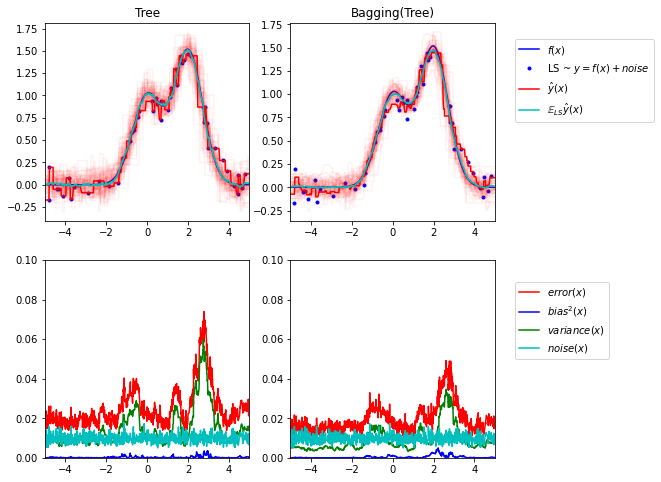

In [34]:
#1.11.1. Bagging meta-estimator
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

In [35]:
# 1.11.3. AdaBoost
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9466666666666665

Automatically created module for IPython interactive environment


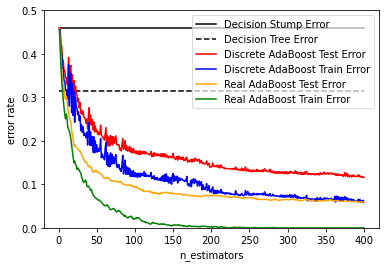

In [36]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html#sphx-glr-auto-examples-ensemble-plot-adaboost-hastie-10-2-py

print(__doc__)

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>,
#         Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 400
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)

X_test, y_test = X[2000:], y[2000:]
X_train, y_train = X[:2000], y[:2000]

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

In [37]:
# 1.11.4. Gradient Tree Boosting¶

# Classification
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.913

In [38]:
# Regression

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X, y = make_regression(random_state=0)

X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)
reg.predict(X_test[1:2])
reg.score(X_test, y_test)

0.43848663277068134

In [39]:
# Este no me corre

# 1.11.5. Histogram-Based Gradient Boosting

#HistGradientBoostingClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier

# from sklearn.ensemble import HistGradientBoostingClassifier
# from sklearn.datasets import load_iris

# X, y = load_iris(return_X_y=True)
# clf = HistGradientBoostingClassifier().fit(X, y)
# clf.score(X, y)

In [40]:
# Este no me corre

# HistGradientBoostingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor

# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.datasets import load_diabetes

# X, y = load_diabetes(return_X_y=True)
# est = HistGradientBoostingRegressor().fit(X, y)
# est.score(X, y)

In [41]:
# 1.11.6. Voting Classifier¶

from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.04) [Logistic Regression]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.04) [Ensemble]


Automatically created module for IPython interactive environment


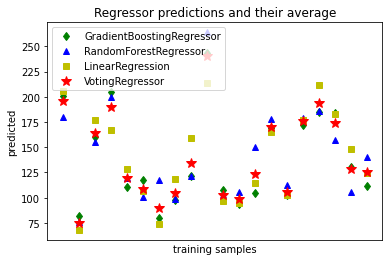

In [42]:
# 1.11.7. Voting Regressor¶
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py


print(__doc__)

import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

X, y = load_diabetes(return_X_y=True)

# Train classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()

reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)

ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg.fit(X, y)

# Making predictions¶
xt = X[:20]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)

# Plot the results¶
plt.figure()
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r*', ms=10, label='VotingRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

In [43]:
#Stacked generalization

# StackingClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

X, y = load_iris(return_X_y=True)
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
              ('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

clf.fit(X_train, y_train).score(X_test, y_test)


0.9473684210526315

In [44]:
# StackingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor

from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

X, y = load_diabetes(return_X_y=True)

estimators = [('lr', RidgeCV()),('svr', LinearSVR(random_state=42))]

reg = StackingRegressor( estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=10,random_state=42))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

reg.fit(X_train, y_train).score(X_test, y_test)

0.3642619780615395